# Week 5 — NLP in the Wild: Sentiment + Confidence Lab (API-based)

This notebook analyzes **API-based sentiment classification** results generated by your project.

It reads two artifacts from the repo root:
- `outputs/sentiment_results.jsonl` (raw per-text results)
- `outputs/confidence_summary.json` (derived stability + confidence metrics)

It then visualizes:
- label distribution
- confidence distribution
- latency distribution
- which texts are flagged for review under your chosen confidence threshold

> **Note:** This notebook is **read-only by default** (no API calls). There is an optional cell to re-run a batch if you want to regenerate outputs (costs API calls).

In [31]:
from __future__ import annotations

import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

def find_repo_root(start: Path | None = None) -> Path:
    """Find repo root by walking upward until we see an 'outputs' directory or '.git'."""
    p = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (p / "outputs").exists() or (p / ".git").exists():
            return p
        p = p.parent
    raise RuntimeError("Could not find repo root. Run from within the repo.")

REPO_ROOT = find_repo_root()
OUTPUTS_DIR = REPO_ROOT / "outputs"

SENTIMENT_RESULTS_PATH = OUTPUTS_DIR / "sentiment_results.jsonl"
CONFIDENCE_SUMMARY_PATH = OUTPUTS_DIR / "confidence_summary.json"

REPO_ROOT, SENTIMENT_RESULTS_PATH, CONFIDENCE_SUMMARY_PATH

# --- Figure and Table output setup ---
EVIDENCE_DIR = OUTPUTS_DIR / "evidence"
EVIDENCE_DIR.mkdir(parents=True, exist_ok=True)

def save_current_fig(filename: str):
    """Save the current matplotlib figure to outputs/evidence."""
    path = EVIDENCE_DIR / filename
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print(f"Saved: {path}")


In [32]:
# Load sentiment results (JSONL)
if not SENTIMENT_RESULTS_PATH.exists():
    raise FileNotFoundError(f"Missing: {SENTIMENT_RESULTS_PATH}. Run the batch script first.")

df = pd.read_json(SENTIMENT_RESULTS_PATH, lines=True)
df.head()

,run_id,project,model,item_index,run_index,text,label,confidence,rationale,elapsed_ms,response_id,logprobs_included
0,run_20260204T115113Z_be993b96,ain_710_wild_nlp_in_the_wild,gpt-5.2,0,0,"I love the design, but the setup was frustrating.",neutral,0.72,"Expresses both positive sentiment (""love the d...",2434.6835,resp_04e882653daa2ce900698332b2cfc48195b235ea9...,True
1,run_20260204T115113Z_be993b96,ain_710_wild_nlp_in_the_wild,gpt-5.2,1,0,This was a complete waste of time.,negative,0.98,"The phrase ""complete waste of time"" expresses ...",1342.2290,resp_05fdca5910f1639f00698332b4f97c81969ccc81a...,True
2,run_20260204T115113Z_be993b96,ain_710_wild_nlp_in_the_wild,gpt-5.2,2,0,Absolutely fantastic experience — would recomm...,positive,0.98,"Uses strongly positive language: ""Absolutely f...",1523.6798,resp_01001ee5ba02994100698332b69328819db1cb75f...,True
3,run_20260204T115113Z_be993b96,ain_710_wild_nlp_in_the_wild,gpt-5.2,3,0,"Yeah, great… just what I needed (eye roll).",negative,0.90,"The phrase ""Yeah, great… just what I needed (e...",1704.3597,resp_033f683c093c661300698332b860cc8190911d9a8...,True


In [33]:
df_fixed = df.head()
# Define a function to drop columns with only a single unique value
def drop_single_unique_value_columns(df, columns):
    for col in columns:
        if df[col].nunique() == 1:
            df.drop(columns=[col], inplace=True)

# Fix all identified problems
single_unique_columns = ['run_id', 'project', 'model', 'run_index', 'logprobs_included']
drop_single_unique_value_columns(df_fixed, single_unique_columns)
df_fixed

,item_index,text,label,confidence,rationale,elapsed_ms,response_id
0,0,"I love the design, but the setup was frustrating.",neutral,0.72,"Expresses both positive sentiment (""love the d...",2434.6835,resp_04e882653daa2ce900698332b2cfc48195b235ea9...
1,1,This was a complete waste of time.,negative,0.98,"The phrase ""complete waste of time"" expresses ...",1342.2290,resp_05fdca5910f1639f00698332b4f97c81969ccc81a...
2,2,Absolutely fantastic experience — would recomm...,positive,0.98,"Uses strongly positive language: ""Absolutely f...",1523.6798,resp_01001ee5ba02994100698332b69328819db1cb75f...
3,3,"Yeah, great… just what I needed (eye roll).",negative,0.90,"The phrase ""Yeah, great… just what I needed (e...",1704.3597,resp_033f683c093c661300698332b860cc8190911d9a8...


In [34]:
df_fixed = df.head()
def drop_constant_column(df, col_name):
    """
    Drops a column from the DataFrame if it contains only a single unique value.
    """
    if df[col_name].nunique() == 1:
        df.drop(columns=[col_name], inplace=True)

# Fixing the identified problems with the df_fixed DataFrame.
drop_constant_column(df_fixed, 'project')  # Removes column with only 1 unique value.
drop_constant_column(df_fixed, 'model')    # Removes column with only 1 unique value.
drop_constant_column(df_fixed, 'run_index')  # Removes column with only 1 unique value.
drop_constant_column(df_fixed, 'logprobs_included')  # Removes column with only 1 unique value.
df_fixed

,run_id,item_index,text,label,confidence,rationale,elapsed_ms,response_id
0,run_20260204T115113Z_be993b96,0,"I love the design, but the setup was frustrating.",neutral,0.72,"Expresses both positive sentiment (""love the d...",2434.6835,resp_04e882653daa2ce900698332b2cfc48195b235ea9...
1,run_20260204T115113Z_be993b96,1,This was a complete waste of time.,negative,0.98,"The phrase ""complete waste of time"" expresses ...",1342.2290,resp_05fdca5910f1639f00698332b4f97c81969ccc81a...
2,run_20260204T115113Z_be993b96,2,Absolutely fantastic experience — would recomm...,positive,0.98,"Uses strongly positive language: ""Absolutely f...",1523.6798,resp_01001ee5ba02994100698332b69328819db1cb75f...
3,run_20260204T115113Z_be993b96,3,"Yeah, great… just what I needed (eye roll).",negative,0.90,"The phrase ""Yeah, great… just what I needed (e...",1704.3597,resp_033f683c093c661300698332b860cc8190911d9a8...


In [35]:
df_fixed = df.head()
def drop_constant_columns(df, constant_columns):
    """
    Drops columns from the DataFrame that contain only one unique value.
    """
    for col in constant_columns:
        if df[col].nunique() == 1:
            df.drop(columns=col, inplace=True)

# Define the constant columns to be fixed
constant_columns = ['project', 'model', 'run_index', 'logprobs_included']

# Fix the identified constant columns
drop_constant_columns(df_fixed, constant_columns)
df_fixed

,run_id,item_index,text,label,confidence,rationale,elapsed_ms,response_id
0,run_20260204T115113Z_be993b96,0,"I love the design, but the setup was frustrating.",neutral,0.72,"Expresses both positive sentiment (""love the d...",2434.6835,resp_04e882653daa2ce900698332b2cfc48195b235ea9...
1,run_20260204T115113Z_be993b96,1,This was a complete waste of time.,negative,0.98,"The phrase ""complete waste of time"" expresses ...",1342.2290,resp_05fdca5910f1639f00698332b4f97c81969ccc81a...
2,run_20260204T115113Z_be993b96,2,Absolutely fantastic experience — would recomm...,positive,0.98,"Uses strongly positive language: ""Absolutely f...",1523.6798,resp_01001ee5ba02994100698332b69328819db1cb75f...
3,run_20260204T115113Z_be993b96,3,"Yeah, great… just what I needed (eye roll).",negative,0.90,"The phrase ""Yeah, great… just what I needed (e...",1704.3597,resp_033f683c093c661300698332b860cc8190911d9a8...


## Basic sanity checks

We expect:
- `label` in {positive, neutral, negative}
- `confidence` in [0, 1]
- `elapsed_ms` positive
- stable grouping keys: `text`, `item_index`, `run_index`, `run_id`

In [36]:
df['label'].value_counts()

label
negative    2
neutral     1
positive    1
Name: count, dtype: int64

In [37]:
df[['confidence', 'elapsed_ms']].describe()

,confidence,elapsed_ms
count,4.00000,4.000000
mean,0.89500,1751.238000
std,0.12261,479.015109
min,0.72000,1342.229000
25%,0.85500,1478.317100
50%,0.94000,1614.019750
75%,0.98000,1886.940650
max,0.98000,2434.683500


## Visualize label distribution

Saved: C:\Users\10260755\PycharmProjects\ain_710_wild_nlp_in_the_wild\outputs\evidence\fig_01_label_distribution.png


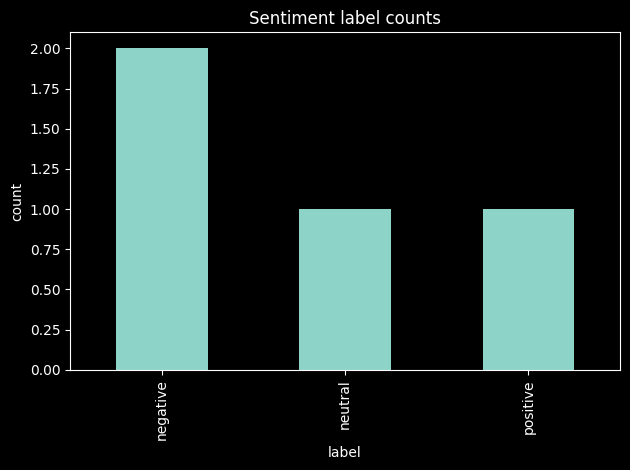

In [38]:
ax = df['label'].value_counts().plot(kind='bar')
ax.set_title('Sentiment label counts')
ax.set_xlabel('label')
ax.set_ylabel('count')
save_current_fig("fig_01_label_distribution.png")
plt.show()

## Confidence distribution

This shows how strongly the model *claims* to believe each classification.
In your discussion post, you can connect this to the idea that **labels alone hide uncertainty**.

Saved: C:\Users\10260755\PycharmProjects\ain_710_wild_nlp_in_the_wild\outputs\evidence\fig_02_confidence_histogram.png


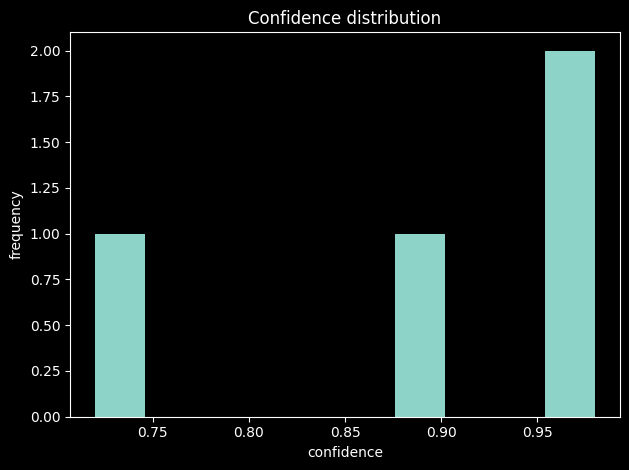

In [39]:
ax = df['confidence'].plot(kind='hist', bins=10)
ax.set_title('Confidence distribution')
ax.set_xlabel('confidence')
ax.set_ylabel('frequency')
save_current_fig("fig_02_confidence_histogram.png")
plt.show()

## Latency distribution (`elapsed_ms`)

This helps you talk about real-world operational constraints: responsiveness, cost, and monitoring.

Saved: C:\Users\10260755\PycharmProjects\ain_710_wild_nlp_in_the_wild\outputs\evidence\fig_03_latency_histogram.png


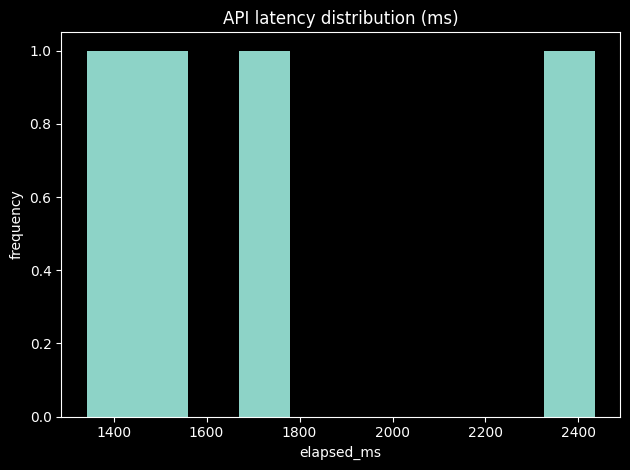

In [40]:
ax = df['elapsed_ms'].plot(kind='hist', bins=10)
ax.set_title('API latency distribution (ms)')
ax.set_xlabel('elapsed_ms')
ax.set_ylabel('frequency')
save_current_fig("fig_03_latency_histogram.png")
plt.show()

## Per-text view (for "NLP in the Wild" narrative)

This table is easy to screenshot or summarize in your discussion post.

In [41]:
cols = ['text', 'label', 'confidence', 'elapsed_ms', 'run_id', 'item_index', 'run_index']
df[cols].sort_values(['item_index','run_index']).reset_index(drop=True)

,text,label,confidence,elapsed_ms,run_id,item_index,run_index
0,"I love the design, but the setup was frustrating.",neutral,0.72,2434.6835,run_20260204T115113Z_be993b96,0,0
1,This was a complete waste of time.,negative,0.98,1342.2290,run_20260204T115113Z_be993b96,1,0
2,Absolutely fantastic experience — would recomm...,positive,0.98,1523.6798,run_20260204T115113Z_be993b96,2,0
3,"Yeah, great… just what I needed (eye roll).",negative,0.90,1704.3597,run_20260204T115113Z_be993b96,3,0


## Optional: Export tables for your discussion post

These exports write to `outputs/evidence/` so you can attach tables or copy values without screenshots.


In [42]:
# --- Export tables to EVIDENCE_DIR ---
df[cols].sort_values(['item_index','run_index']).to_csv(EVIDENCE_DIR / "per_text_results.csv", index=False)
print(f"Wrote: {EVIDENCE_DIR / 'per_text_results.csv'}")


Wrote: C:\Users\10260755\PycharmProjects\ain_710_wild_nlp_in_the_wild\outputs\evidence\per_text_results.csv


## Load derived confidence/stability summary

This summary is computed by `src/lab/confidence.py` and is where your governance threshold shows up.

If you used `low_conf_threshold=0.70`, mixed/ambiguous texts should be flagged for review.

In [43]:
if not CONFIDENCE_SUMMARY_PATH.exists():
    raise FileNotFoundError(f"Missing: {CONFIDENCE_SUMMARY_PATH}. Run run_confidence.py first.")

with CONFIDENCE_SUMMARY_PATH.open('r', encoding='utf-8') as f:
    summaries = json.load(f)

df_sum = pd.DataFrame(summaries)
df_sum.sort_values('confidence_mean')
df_sum.to_csv(EVIDENCE_DIR / "confidence_summary.csv", index=False)
print(f"Wrote: {EVIDENCE_DIR / 'confidence_summary.csv'}")


Wrote: C:\Users\10260755\PycharmProjects\ain_710_wild_nlp_in_the_wild\outputs\evidence\confidence_summary.csv


## Flagged for review

These are the items where your policy says: **"Don’t trust the label alone — route to review."**

In [44]:
df_sum[df_sum['low_confidence_flag'] == True].sort_values('confidence_mean')

,group_by,group_key,n_runs,label_mode,label_mode_count,label_flip_count,label_flip_rate,confidence_mean,confidence_std,confidence_min,confidence_max,low_confidence_flag,unstable_flag,project,model


## Optional: Re-run batch (costs API calls)

Uncomment and run this cell only if you want to regenerate results.

Tip: set `n_runs_per_text=5` to make stability/variance more interesting.

In [45]:
# from src.lab.sentiment import build_default_context
# from src.lab.sentiment_batch import BatchConfig, run_sentiment_batch
#
# ctx = build_default_context()
#
# results = run_sentiment_batch(
#     ctx=ctx,
#     texts=[
#         "I love the design, but the setup was frustrating.",
#         "This was a complete waste of time.",
#         "Absolutely fantastic experience — would recommend.",
#         "Yeah, great… just what I needed (eye roll).",
#     ],
#     config=BatchConfig(n_runs_per_text=5, temperature=0.7, write_results_jsonl=True),
# )
#
# print(f"Wrote {len(results)} records to: {OUTPUTS_DIR / 'sentiment_results.jsonl'}")

## Discussion-post hooks

- **Label vs confidence:** show that mixed sentiment can be labeled consistently but with lower confidence.
- **Operational reality:** latency varies; monitoring and fallbacks matter.
- **Governance:** define a threshold (e.g., 0.70) where ambiguous outputs route to human review.
- **Bias/insensitivity:** propose test sets with dialect, sarcasm, idioms, and domain language; measure label flips and confidence drops.